In [1]:
import pickle
import sys
from pathlib import Path

import tqdm

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from scipy import stats
from torch.utils.data import DataLoader, Dataset

In [2]:
submission_path = Path("../XTXStarterKit/").as_posix()
if submission_path not in sys.path:
    sys.path.insert(0, submission_path)

In [3]:
import python.utils
import python.model

In [4]:
pd.set_option("max_columns", 10000)
pd.set_option("max_rows", 10000)

In [5]:
%load_ext autoreload
%autoreload 2

## Functions

In [6]:
def fix_input_df(df):
    ask_rate_cols = [c for c in df.columns if c.startswith("askRate")]
    bid_rate_cols = [c for c in df.columns if c.startswith("bidRate")]
    ask_size_cols = [c for c in df.columns if c.startswith("askSize")]
    bid_size_cols = [c for c in df.columns if c.startswith("bidSize")]

    df[ask_rate_cols] = np.where(
        df[ask_rate_cols].isnull(),
        np.repeat(df[ask_rate_cols].max(axis=1)[:, None], 15, 1),
        df[ask_rate_cols],
    )

    df[bid_rate_cols] = np.where(
        df[bid_rate_cols].isnull(),
        np.repeat(df[bid_rate_cols].min(axis=1)[:, None], 15, 1),
        df[bid_rate_cols],
    )

    df[ask_size_cols] = df[ask_size_cols].fillna(1)
    df[bid_size_cols] = df[bid_size_cols].fillna(1)

    data_cols = ask_rate_cols + bid_rate_cols + ask_size_cols + bid_size_cols
    other_cols = [c for c in df.columns if c not in data_cols]
    df = df[data_cols + other_cols]

    return df

### Load data

In [7]:
data_training = pd.read_csv("../data/data-training.csv.gz")

In [8]:
rate_cols = [c for c in data_training.columns if "Rate" in c]
size_cols = [c for c in data_training.columns if "Size" in c]
other_cols = [c for c in data_training.columns if c not in rate_cols and c not in size_cols]
data_training = data_training[rate_cols + size_cols + other_cols]

In [9]:
display(data_training.head(2))
print(len(data_training))

askRate0  askRate1  askRate2  askRate3  askRate4  askRate5  askRate6  \
0    1619.5    1620.0    1621.0       NaN       NaN       NaN       NaN   
1    1619.5    1620.0    1621.0    1621.5       NaN       NaN       NaN   

   askRate7  askRate8  askRate9  askRate10  askRate11  askRate12  askRate13  \
0       NaN       NaN       NaN        NaN        NaN        NaN        NaN   
1       NaN       NaN       NaN        NaN        NaN        NaN        NaN   

   askRate14  bidRate0  bidRate1  bidRate2  bidRate3  bidRate4  bidRate5  \
0        NaN    1615.0    1614.0    1613.0    1612.0    1611.0    1610.0   
1        NaN    1615.0    1614.0    1613.0    1612.0    1611.0    1610.0   

   bidRate6  bidRate7  bidRate8  bidRate9  bidRate10  bidRate11  bidRate12  \
0    1607.0    1606.0    1605.0    1604.0     1603.0     1602.0     1601.5   
1    1607.0    1606.0    1605.0    1604.0     1603.0     1602.0     1601.5   

   bidRate13  bidRate14  askSize0  askSize1  askSize2  askSize3  askSize4  \
0     1601.0     1600.0       1.0      10.0      24.0       NaN       NaN   
1     1601.0     1600.0       1.0      10.0      24.0       5.0       NaN   

   askSize5  askSize6  askSize7  askSize8  askSize9  askSize10  askSize11  \
0       NaN       NaN       NaN       NaN       NaN        NaN        NaN   
1       NaN       NaN       NaN       NaN       NaN        NaN        NaN   

   askSize12  askSize13  askSize14  bidSize0  bidSize1  bidSize2  bidSize3  \
0        NaN        NaN        NaN       7.0      10.0       1.0      10.0   
1        NaN        NaN        NaN       7.0      10.0       1.0      10.0   

   bidSize4  bidSize5  bidSize6  bidSize7  bidSize8  bidSize9  bidSize10  \
0      20.0       3.0      20.0      27.0      11.0      14.0       35.0   
1      20.0       3.0      20.0      27.0      11.0      14.0       35.0   

   bidSize11  bidSize12  bidSize13  bidSize14    y  
0       10.0        1.0       10.0       13.0 -0.5  
1       10.0        1.0       10.0       13.0 -0.5

2999999


In [10]:
data_training = fix_input_df(data_training)

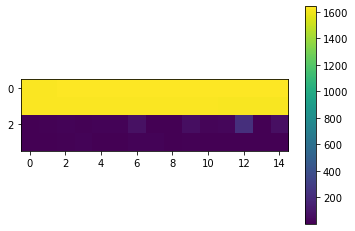

In [11]:
plt.imshow(data_training.drop("y", axis=1).iloc[100200].astype(np.float32).values.reshape(4, 15))
plt.colorbar()

In [12]:
df = data_training.copy()

ask_rate_cols = [c for c in df.columns if c.startswith("askRate")]
bid_rate_cols = [c for c in df.columns if c.startswith("bidRate")]
ask_size_cols = [c for c in df.columns if c.startswith("askSize")]
bid_size_cols = [c for c in df.columns if c.startswith("bidSize")]
other_cols = ["y"]

In [13]:
TRAIN_TEST_SPLITS = []
for i in range(5):
    start = int(len(data_training) * 0.2 * i)
    stop = int(len(data_training) * 0.2 * (i + 1))

    train_df = pd.concat([data_training.iloc[:start], data_training.iloc[stop:]]).copy()
    valid_df = data_training.iloc[start:stop].copy()
    assert len(train_df) + len(valid_df) == len(data_training)
    assert not set(train_df.index) & set(valid_df.index)

    # Size
    train_df[ask_size_cols + bid_size_cols] = np.log(
        train_df[ask_size_cols + bid_size_cols].values
    )
    valid_df[ask_size_cols + bid_size_cols] = np.log(
        valid_df[ask_size_cols + bid_size_cols].values
    )

    max_size = train_df[ask_size_cols + bid_size_cols].values.max()
    train_df[ask_size_cols + bid_size_cols] = (
        train_df[ask_size_cols + bid_size_cols].values / max_size
    )
    valid_df[ask_size_cols + bid_size_cols] = (
        valid_df[ask_size_cols + bid_size_cols].values / max_size
    )

    # Rate
    rate_mean = train_df[ask_rate_cols + bid_rate_cols].values.mean()
    rate_range = (
        train_df[ask_rate_cols + bid_rate_cols].values.max()
        - train_df[ask_rate_cols + bid_rate_cols].values.min()
    )

    train_df[ask_rate_cols + bid_rate_cols] = (
        train_df[ask_rate_cols + bid_rate_cols].values - rate_mean
    ) / rate_range
    valid_df[ask_rate_cols + bid_rate_cols] = (
        valid_df[ask_rate_cols + bid_rate_cols].values - rate_mean
    ) / rate_range

    TRAIN_TEST_SPLITS.append((train_df, valid_df))

In [14]:
train_df, valid_df = TRAIN_TEST_SPLITS[0]

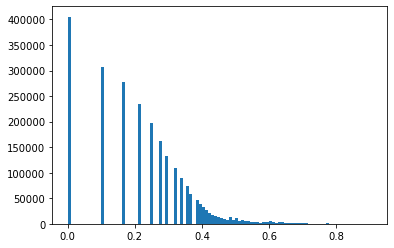

In [16]:
_ = plt.hist(train_df["askSize0"], bins=100)

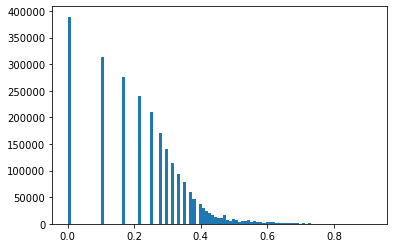

In [15]:
_ = plt.hist(train_df["bidSize0"], bins=100)

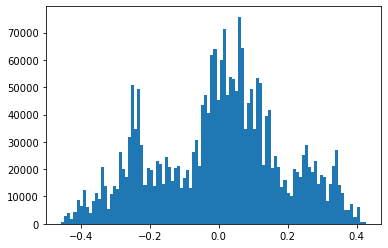

In [23]:
_ = plt.hist(train_df["askRate0"], bins=100)

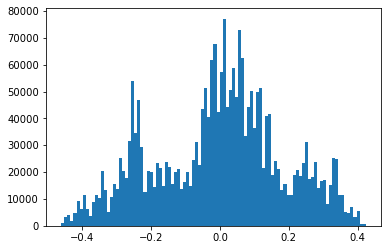

In [36]:
_ = plt.hist(train_df["bidRate0"], bins=100)

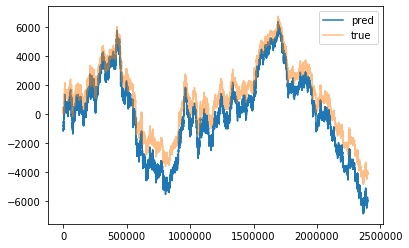

In [30]:
plt.plot(train_df["askRate0"].values * 15000, label="pred")
plt.plot(np.cumsum(train_df["y"].values), label="true", alpha=0.5)
plt.legend(loc="upper right")

In [32]:
stats.pearsonr(train_df["y"].values[:-1], train_df["askRate0"].values[1:] - train_df["askRate0"].values[:-1])

(0.08296264915700255, 0.0)

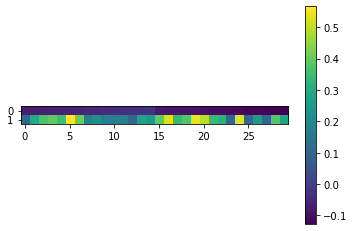

In [34]:
plt.imshow(train_df.iloc[:1].drop("y", axis=1).values.reshape(2, 30))
plt.colorbar()